<a href="https://colab.research.google.com/github/KeiShiba-1218/ColabNotebooks/blob/main/ResNet_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet Inplementation with Colab TPU in 05 Jan 2021
This is the inplementation of resnet with tensorflow 2.x

#Import modules

In [ ]:
import os
import glob
import time
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

print(tf.__version__)

2.4.0


##Preparing for using TPU
###Connecting to TPU server

In [ ]:
tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
strategy = tf.distribute.TPUStrategy(tpu_cluster_resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.62.65.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.62.65.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


###Decorator for simplifying TPU training

In [ ]:
from enum import Enum

class Reduction(Enum):
    NONE = 0
    SUM = 1
    MEAN = 2
    CONCAT = 3

def distributed(*reduction_flags):
    # Reduction flag is what you want the tensor returning from each TPU to do.
    def _decorator(fun):
        def per_replica_reduction(z, flag):
            if flag == Reduction.NONE:
                return z
            elif flag == Reduction.SUM:
                return strategy.reduce(tf.distribute.ReduceOp.SUM, z, axis=None)
            elif flag == Reduction.MEAN:
                return strategy.reduce(tf.distribute.ReduceOp.MEAN, z, axis=None)
            elif flag == Reduction.CONCAT:
                z_list = strategy.experimental_local_results(z)
                return tf.concat(z_list, axis=0)
            else:
                raise NotImplementedError()
        
        @tf.function
        def _decorated_fun(*args, **kwargs):
            fun_result = strategy.run(fun, args=args, kwargs=kwargs)
            if len(reduction_flags) == 0:
                assert fun_result is None
                return
            elif len(reduction_flags) == 1:
                assert type(fun_result) is not tuple and fun_result is not None
                return per_replica_reduction(fun_result, *reduction_flags)
            else:
                assert type(fun_result) is tuple
                return tuple((per_replica_reduction(fr, rf) for fr, rf in zip(fun_result, reduction_flags)))
        return _decorated_fun
    return _decorator

#Create dataset

In [ ]:
def load_cifar10(batch_size):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    def data_augmentation(img):
        x = tf.cast(img, tf.float32) / 127.5 - 1.0 # [-1, 1]
        x = tf.image.random_flip_left_right(x)
        # padding to change size to (34, 34, 3)
        x = tf.pad(x, tf.constant([[2, 2], [2, 2], [0, 0]]), mode='REFLECT')
        x = tf.image.random_crop(x, size=[32, 32, 3])
        return x

    trainset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    trainset = trainset.map(
        lambda img, label: (data_augmentation(img), tf.cast(label, tf.float32))
    ).shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    testset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    testset = testset.map(
        lambda img, label: (tf.cast(img, tf.float32)/127.5-1.0, tf.cast(label, tf.float32))
    ).shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return trainset, testset

# If you use TPU, you can use large batch size!
BATCH_SIZE = 1024
trainset, testset = load_cifar10(BATCH_SIZE)

170500096/170498071 [==============================] - 2s 0us/step


##Check images

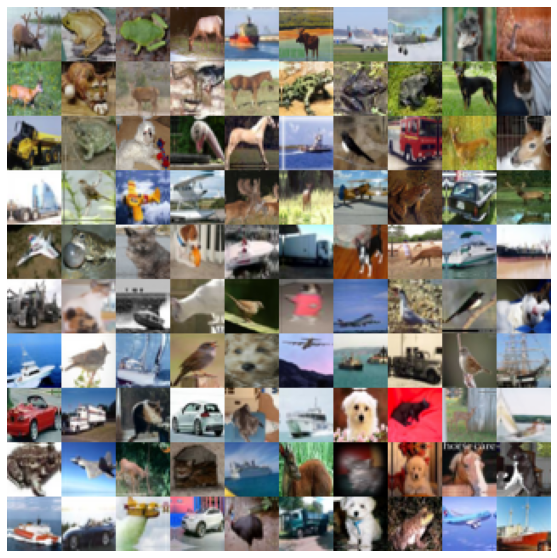

In [ ]:
def make_grid(imgs, nrow, padding=0):
    # ndarray 4th floor tensors(images) -> image listed images
    assert imgs.ndim == 4 and nrow > 0
    batch, height, width, ch = imgs.shape
    n = nrow * (batch // nrow + np.sign(batch % nrow))
    ncol = n // nrow
    pad = np.zeros((n-batch, height, width, ch), imgs.dtype)
    x = np.concatenate([imgs, pad], axis=0)
    if padding > 0:
        x = np.pad(x, ((0, 0), (0, padding), (0, padding), (0, 0)), 
                   'constant', constant_values=(0, 0))
        height += padding
        width += padding
    x = x.reshape(ncol, nrow, height, width, ch)
    x = x.transpose([0, 2, 1, 3, 4])
    x = x.reshape(height*ncol, width*nrow, ch)
    if padding > 0:
        x = x[:(height*ncol - padding), :(width*nrow - padding), :]
    return x

def plot_images(images, nrow=10, padding=0, img_name='sample_img.png', plotting=True):
    imgs = images.numpy()
    grid = make_grid(imgs, nrow, padding)
    grid = ((grid+1)*127.5).astype(np.uint8) # [0, 255]
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(grid)
    plt.savefig(img_name, bbox_inches='tight', pad_inches=0.0)
    if plotting: plt.show()
    plt.close('all')

BATCH_SIZE = 1024
trainset, testset = load_cifar10(BATCH_SIZE)

temp1, temp2 = next(iter(trainset))
plot_images(temp1[:100])

#Create network

In [ ]:
BATCH_SIZE = 1024

def ch(res):
    c = 1024 // res * 2
    if c > 1024: c = 1024
    if c < 64: c = 64
    return c

def net_block(x, res, downsampling=False):
    if downsampling:
        res = res//2
        a = AveragePooling2D()(x)
    else:
        a = x
    a = Conv2D(ch(res), 1)(a)

    x = BatchNormalization()(x)
    x = ReLU()(x)
    if downsampling:
        x = AveragePooling2D()(x)
    x = Conv2D(ch(res), kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(ch(res), kernel_size=3, strides=1, padding='same')(x)

    x = Add()([x, a])
    return x

def create_net():
    inputs = Input((32,32,3))
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    for i, res in enumerate([32, 16, 8]):
        x = net_block(x, res, downsampling=False)
        x = net_block(x, res, downsampling=True)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)
    out = Dense(10)(x) # output is logit
    return Model(inputs, out)

##Check network summary and arcitecture

In [ ]:
K.clear_session()

create_net().summary()
tf.keras.utils.plot_model(create_net(), 'net_graph.png', show_shapes=True)
print()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#Training
##Check learning rate

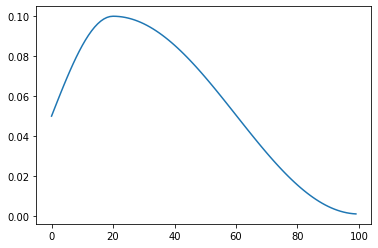

In [ ]:
EPOCH = 100

def set_lr(epoch, init_lr=5e-2, max_lr=1e-1, min_lr=1e-3, warm_up_period=20):
    e = epoch; w = warm_up_period
    if e<w:
        lr = (max_lr-init_lr)*np.sin(np.pi*e/(2*w)) + init_lr
    else:
        lr = (max_lr-min_lr)/2.0*np.cos((e-w)*np.pi/(EPOCH-w)) + (max_lr+min_lr)/2.0
    return lr

lrs = []
for i in range(EPOCH):
    lrs.append(set_lr(i))

plt.figure()
plt.plot(lrs)
plt.show()

In [ ]:
K.clear_session()

BATCH_SIZE = 1024
STEPS_PER_EPOCH_TRAIN = 50000 // BATCH_SIZE + 1
STEPS_PER_EPOCH_TEST = 10000 // BATCH_SIZE + 1
EPOCH = 100

out_dir = 'out'
os.makedirs(out_dir, exist_ok=True)

with strategy.scope():
    net = create_net()
    opt = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)

    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_acc = tf.keras.metrics.CategoricalAccuracy()

    trainset, testset = load_cifar10(BATCH_SIZE)
    # Convert trainset & testset to send PerReplica
    trainset = strategy.experimental_distribute_dataset(trainset)
    testset = strategy.experimental_distribute_dataset(testset)

    def set_lr(epoch, init_lr=5e-2, max_lr=1e-1, min_lr=1e-3, warm_up_period=20):
        e = epoch; w = warm_up_period
        if e<w:
            lr = (max_lr-init_lr)*np.sin(np.pi*e/(2*w)) + init_lr
        else:
            lr = (max_lr-min_lr)/2.0*np.cos((e-w)*np.pi/(EPOCH-w)) + (max_lr+min_lr)/2.0
        return lr

    def loss_func(y, p):
        return -tf.reduce_sum(y*tf.math.log(p)) / BATCH_SIZE
    
    @distributed(Reduction.SUM)
    def train_on_batch(img, y):
        with tf.GradientTape() as tape:
            logits = net(img, training=True)
            p = tf.math.softmax(logits)
            loss = loss_func(y, p)
            train_acc.update_state(y, p)
        grad = tape.gradient(loss, net.trainable_weights)
        opt.apply_gradients(zip(grad, net.trainable_weights))
        return loss
    
    @distributed(Reduction.SUM)
    def test_on_batch(img, y):
        logits = net(img, training=False)
        p = tf.math.softmax(logits)
        loss = loss_func(y, p)
        val_acc.update_state(y, p)
        return loss

    data = []
    total_step = 0
    t0 = time.time()
    
    for epoch in range(EPOCH):
        t1 = time.time()
        print(f'Epoch: {str(epoch).zfill(3)}')
        train_acc.reset_states()
        val_acc.reset_states()
        opt.lr = set_lr(epoch, init_lr=5e-2, max_lr=1e-1, min_lr=1e-3, warm_up_period=20)

        for step, (img, label) in enumerate(trainset):
            train_loss = train_on_batch(img, label)
            if step%(STEPS_PER_EPOCH_TRAIN//2)==0:
                print(f'\tStep {str(total_step).zfill(7)}, train_loss: {train_loss.numpy():f}, train_acc: {train_acc.result().numpy():f}')
            total_step += 1
        
        for step, (img, label) in enumerate(testset):
            val_loss = test_on_batch(img, label)
        print(f'\tval_loss: {val_loss.numpy():f}, val_acc: {val_acc.result().numpy():f}')
        data.append([epoch, opt.lr.numpy(), train_loss.numpy(), val_loss.numpy(), train_acc.result().numpy(), val_acc.result().numpy()])

        print(f'{time.time()-t1:f}s is elapsed for epoch {str(epoch).zfill(3)}.')
    with open(f'data.pkl', 'wb') as fp: pickle.dump(data, fp)
    print(f'Train time: {(time.time()-t0)/60:f}min.')

Epoch: 000
	Step 0000000, train_loss: 2.658062, train_acc: 0.056641
	Step 0000024, train_loss: 1.529287, train_acc: 0.344961
	Step 0000048, train_loss: 1.051837, train_acc: 0.414460
	val_loss: 1.683210, val_acc: 0.183000
28.000380s is elapsed for epoch 000.
Epoch: 001
	Step 0000049, train_loss: 1.279262, train_acc: 0.542969
	Step 0000073, train_loss: 1.114269, train_acc: 0.577461
	Step 0000097, train_loss: 0.788485, train_acc: 0.602740
	val_loss: 1.752775, val_acc: 0.220600
6.294513s is elapsed for epoch 001.
Epoch: 002
	Step 0000098, train_loss: 0.993756, train_acc: 0.647461
	Step 0000122, train_loss: 0.851326, train_acc: 0.682773
	Step 0000146, train_loss: 0.647414, train_acc: 0.699560
	val_loss: 1.644525, val_acc: 0.303600
6.024692s is elapsed for epoch 002.
Epoch: 003
	Step 0000147, train_loss: 0.765748, train_acc: 0.722656
	Step 0000171, train_loss: 0.701247, train_acc: 0.741211
	Step 0000195, train_loss: 0.490566, train_acc: 0.750180
	val_loss: 1.199375, val_acc: 0.476700
6.20214

##Check learning curve

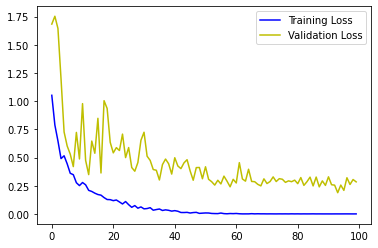

<Figure size 432x288 with 0 Axes>

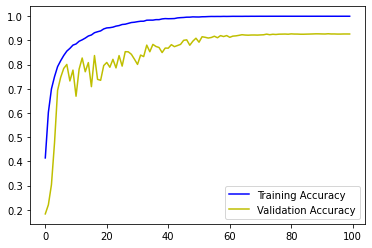

<Figure size 432x288 with 0 Axes>

In [ ]:
data = np.array(data)
epoch = data[:, 0]
lr = data[:, 1]
train_loss = data[:, 2]
val_loss = data[:, 3]
train_acc = data[:, 4]
val_acc = data[:, 5]

plt.figure()
plt.plot(epoch, train_loss, 'b', label='Training Loss')
plt.plot(epoch, val_loss, 'y', label='Validation Loss')
#plt.ylim(0.0, 1.0)
plt.legend()
plt.savefig('losses.png')
plt.show()
plt.clf()

plt.figure()
plt.plot(epoch, train_acc, 'b', label='Training Accuracy')
plt.plot(epoch, val_acc, 'y', label='Validation Accuracy')
#plt.ylim(0.75, 1.0)
plt.legend()
plt.savefig('accuracies.png')
plt.show()
plt.clf()